# Training with Distance Weight

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score

# created library
import mydata
from mymodels import TransDataset, LoadDataset, EfficientB3Model
import training

In [2]:
# to reproduce

seed = 42
random.seed(seed) #　ほかのモジュールで使われているかも
np.random.seed(seed) # ほかのモジュールで使われているかも
torch.manual_seed(seed) # Pytorchの中のシード
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True # GPUの計算過程の変化をさせない

In [3]:
db = "UTKFace"
root = f"../../dataset/AAAI 2025/{db}/"
polynomial_save_file = f"{root}model/pickle/polynomial_model_ef3.pkl"

# Load model
with open(polynomial_save_file, "rb") as f:
    polynomial_model = pickle.load(f)

Validation_MEAN = 0.93

In [4]:
# Test
polynomial_model(np.array([45, 50]))

array([0.89438329, 0.88501618])

In [5]:
df_train = mydata.load_and_process_csv(f"{root}/dataframe/df_train.csv")
df_valid = mydata.load_and_process_csv(f"{root}/dataframe/df_valid.csv")
df_test = mydata.load_and_process_csv(f"{root}/dataframe/df_test.csv")

In [11]:
def calculate_distance_penalty(distances):
    diff = Validation_MEAN - polynomial_model(np.array(distances))
    diff = torch.tensor(diff.mean())
    return diff

In [12]:
ycol="labels"
batch_size = 1 # １インプットずつペナルティを付加するため

ld = LoadDataset(df_train, df_valid, df_test, ycol, batch_size)
train_loader, valid_loader, test_loader = ld.create_dataloaders()

H*W:  (200, 200)


In [13]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

class CustomBCEWithLogitsLoss(nn.Module):
    def __init__(self):
        super(CustomBCEWithLogitsLoss, self).__init__()

    def forward(self, outputs, targets, distances, device): # criterion
        #print("outputs", outputs[0])
        outputs = outputs.view(-1)
        #print("targets", targets)
        bce_loss = F.binary_cross_entropy(torch.sigmoid(outputs), targets) # due to batch size=1
        #bce_loss = F.binary_cross_entropy(torch.sigmoid(outputs), targets)
        penalty = calculate_distance_penalty(distances).to(device)
        #print("bce_loss", bce_loss)
        #print("penalty", penalty)
        penalty = penalty * 0.0000001
        return bce_loss + penalty

In [14]:
def train_model(model, train_loader, valid_loader, num_epochs=25, lr=1e-5, weight_decay=1e-4):

    train_losses = []
    valid_losses = []
    train_f1s = []
    valid_f1s = []
    train_aucs = []
    valid_aucs = []
    train_accuracies = []
    valid_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    criterion = CustomBCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        for inputs, labels, distances in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) # data -> GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            #loss = criterion(outputs.squeeze(), labels, distances, device)
            loss = criterion(outputs, labels, distances, device) # due to batch size=1
            loss.backward() # Partial Derivative
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            all_preds.extend(outputs.detach().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_f1 = f1_score(all_labels, [1 if x >= 0 else 0 for x in all_preds])
        epoch_auc = roc_auc_score(all_labels, all_preds)
        epoch_acc = accuracy_score(all_labels, [1 if x >= 0 else 0 for x in all_preds])

        train_losses.append(epoch_loss)
        train_f1s.append(epoch_f1)
        train_aucs.append(epoch_auc)
        train_accuracies.append(epoch_acc)

        #print(f'Epoch {epoch}/{num_epochs - 1} | Loss: {epoch_loss:.4f} | F1: {epoch_f1:.4f} | AUC: {epoch_auc:.4f}')
        
        model.eval() # Validation だから。
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for inputs, labels, distances in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device) # data -> GPU
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels, distances, device)
                
                val_loss += loss.item() * inputs.size(0)
                val_preds.extend(outputs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(valid_loader.dataset)
        val_f1 = f1_score(val_labels, [1 if x >= 0.5 else 0 for x in val_preds])
        val_auc = roc_auc_score(val_labels, val_preds)
        val_acc = accuracy_score(val_labels, [1 if x >= 0.5 else 0 for x in val_preds])

        valid_losses.append(val_loss)
        valid_f1s.append(val_f1)
        valid_aucs.append(val_auc)
        valid_accuracies.append(val_acc)

        print(f'Validation Accuracy: {val_acc:.4f} | Loss: {val_loss:.4f} | F1: {val_f1:.4f} | AUC: {val_auc:.4f}')

    epochs = range(num_epochs)
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Valid Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_f1s, label='Train F1 Score')
    plt.plot(epochs, valid_f1s, label='Valid F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score')
    plt.legend()

    plt.show()

Validation Accuracy: 0.5134 | Loss: 1.1207 | F1: 0.1557 | AUC: 0.5585
Validation Accuracy: 0.4975 | Loss: 3.4184 | F1: 0.0116 | AUC: 0.5392
Validation Accuracy: 0.5088 | Loss: 5.0512 | F1: 0.0684 | AUC: 0.5918
Validation Accuracy: 0.5273 | Loss: 4.1861 | F1: 0.1683 | AUC: 0.5853
Validation Accuracy: 0.5520 | Loss: 7.3624 | F1: 0.2563 | AUC: 0.6029
Validation Accuracy: 0.5701 | Loss: 5.6146 | F1: 0.3135 | AUC: 0.6499
Validation Accuracy: 0.6011 | Loss: 6.7916 | F1: 0.4349 | AUC: 0.6157
Validation Accuracy: 0.6359 | Loss: 5.0730 | F1: 0.5124 | AUC: 0.6715
Validation Accuracy: 0.6267 | Loss: 1.8322 | F1: 0.5028 | AUC: 0.6769
Validation Accuracy: 0.5457 | Loss: 12.4137 | F1: 0.2314 | AUC: 0.5788
Validation Accuracy: 0.6367 | Loss: 5.2119 | F1: 0.4900 | AUC: 0.6763
Validation Accuracy: 0.6049 | Loss: 6.4549 | F1: 0.5124 | AUC: 0.6121
Validation Accuracy: 0.6275 | Loss: 9.1244 | F1: 0.5011 | AUC: 0.6574
Validation Accuracy: 0.6053 | Loss: 10.7447 | F1: 0.4507 | AUC: 0.6479
Validation Accurac

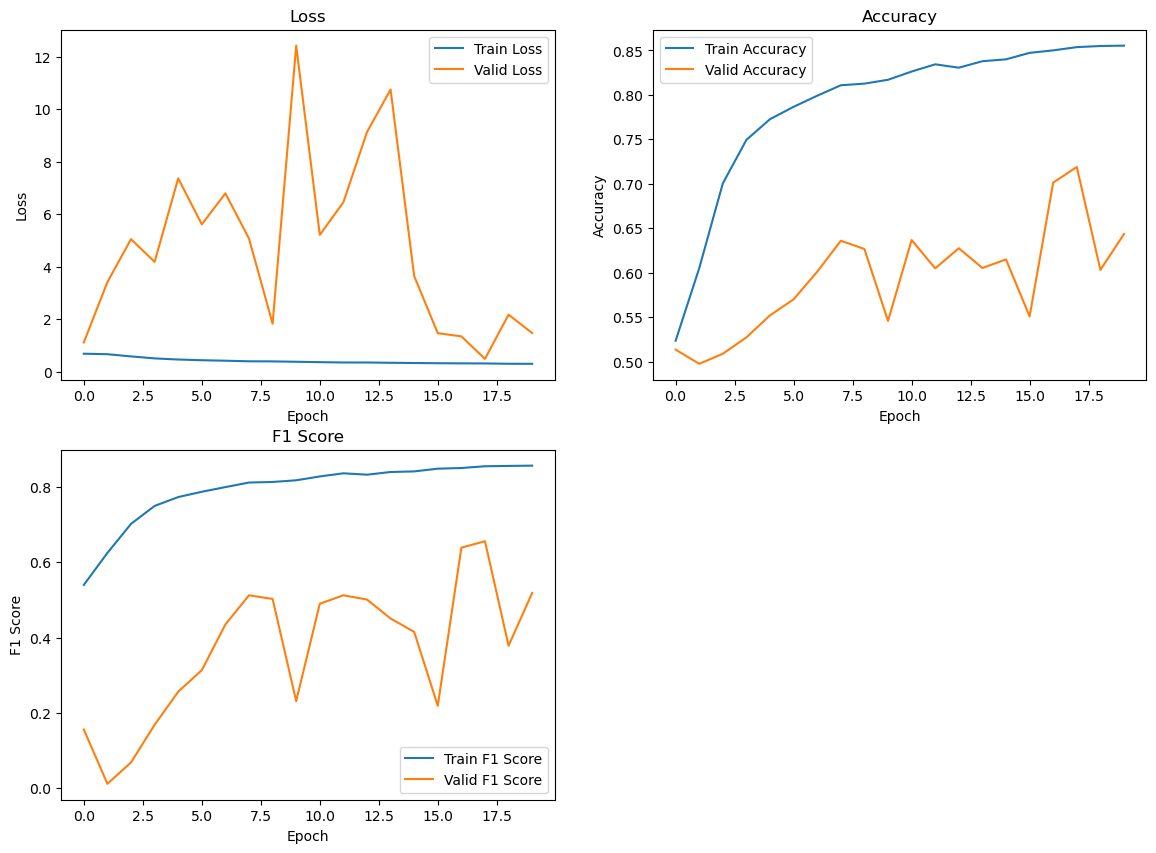

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientB3Model().to(device) # model -> GPU

num_epochs = 20
lr = 0.00001
train_model(model, train_loader, valid_loader, num_epochs=num_epochs, lr=lr)

In [ ]:
def evaluate_model(model, valid_loader):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval() # 評価モードに入る。dropoutは学習にしか使わない。dropoutはノイズを入れている。ノイズに耐えられるように。
    with torch.no_grad():
        test_predictions = []
        test_outputs = []
        for inputs, labels, _ in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device) # data -> GPU
            outputs = model(inputs)
            # _, test_predictions = torch.max(outputs, 1) # outputsの大きい方が選ばれるけど、二値分類なので異なる
            test_outputs.append(outputs)
            test_predictions.extend(1 if x >= 0 else 0 for x in outputs) # Appendは１つ、extendは複数
    
    return test_predictions

In [ ]:
test_predictions = evaluate_model(model, valid_loader)

In [ ]:
df["predictions"] = test_predictions

In [ ]:
train.test_classification_report(df_valid)